# Diagnosing Spatial Autocorrelation
#### Let's take an example of spatial distribution of Social Vulnerability (SV) scores for OHIO (<a href='https://svi.cdc.gov/Documents/Data/2016_SVI_Data/SVI2016Documentation.pdf'>SVI</a>) and check whether the vulnerability score exhibit positive,negative, zero spatial autocorrelation.

count    2948.000000
mean       -2.890439
std        58.124634
min      -999.000000
25%         0.247425
50%         0.498100
75%         0.749175
max         1.000000
Name: RPL_THEMES, dtype: float64
count    2938.000000
mean        0.499995
std         0.288822
min         0.000000
25%         0.250000
50%         0.500000
75%         0.750000
max         1.000000
Name: RPL_THEMES, dtype: float64


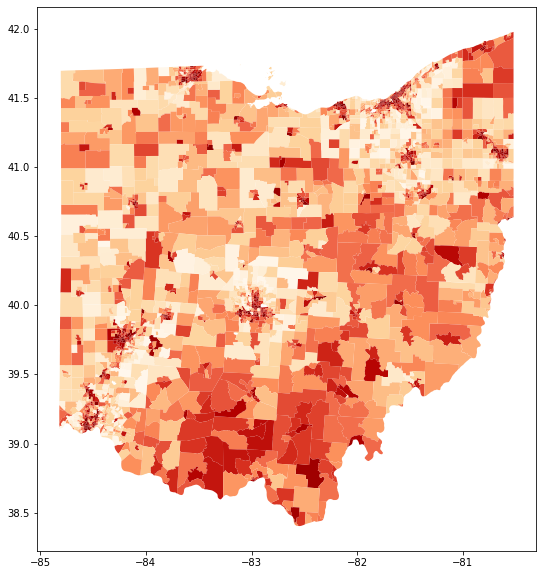

In [23]:
#Load the OHIO SVI data based on census tracts
import geopandas as gpd
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
oh_svi=gpd.read_file(r'../class_data/Ohio_svi_2018/SVI2018_OHIO_tract.shp')
#print few rows of data and check the attributes
#print (oh_svi.head())
#print few columns to check
#print (oh_svi.columns.values.tolist())
#we will use the RPL_THEMES field which contains an overall tract summary ranking.
#if you want to see the stats for a particular variable
print (oh_svi.RPL_THEMES.describe())
#from checking the stats we find that the minimum value is -999, 
#which generally indicate "No data" value or null value. This shouldn't be used for calculations.
#From looking at the docmentation for SVI, the the valid RPL_THEMES are between 0 and 1
#let's see which are the tracts that doesnot have RPL_THEMES between 0 and 1. The ~ value negates a condition and & is equivalent to And
#print (oh_svi[~((oh_svi.RPL_THEMES>=0)&(oh_svi.RPL_THEMES<=1))])
#There are 10 tracts that are having RPL_THEMES values that are not within range 0 and 1. Remove them and create a new dataset
oh_svi_valid=oh_svi[(oh_svi.RPL_THEMES>=0)&(oh_svi.RPL_THEMES<=1)]
#check stats again. now the values seems to be within range
print (oh_svi_valid.RPL_THEMES.describe())
#Now plot the RPL_THEMES variable as a choropleth map
oh_svi_valid.plot(column='RPL_THEMES', cmap='OrRd',ax=ax);
#fig.savefig('../images/oh_svi.png',dpi=300)

![Package](../images/oh_svi.png)

#### Do you see any <span STYLE='font-size:18.0pt'> clustering??</span> 

It seems there is some clustering. Though our visual senses can, in some cases, discern clustered regions from non-clustered regions, the distinction may not always be so obvious. So we need to come up with a quantitative and objective approach for quantifying the degree to which similar features cluster.

## Global Measures of Spatial Autocorrelation
Tests for global spatial autocorrelation examine whether the data as a whole exhibit spatial autocorrelation (against a null of spatial randomness) as well as the strength and direction (positive and negative) of any spatial autocorrelation. 
Positive - Similar values close to each other (high-high, low-low)
Negative - Similar values far from each other (high-low)

![Package](../images/positive_negative_spatial_auto.png)


### Moran Plot
Moran plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is a plot between variable of interest and its *spatial lag*.

##### Spatial Lag
The *spatial lag* is calculated by multiplying the varaible of interest with the corresponding spatial weight. 

$$Y_{sl} = WY\\Y_{sl-i} = \sum_{j}w_{ij}y_j$$
Where *Y<sub>sl</sub>* is the spatial lag for the variable *Y* and *W* is the weight matrix and *Y<sub>sl-i</sub>* is the spatial lag for *Y* at location *i* which is calculated as the sum of spatial lag of all the *Y* values that are with in the neighborhood of *Y<sub>i</sub>*.
If W is standardized, the spatial lag is the *average value of the variable in the neighborhood*.
In order to be able to interpret values as above or below the mean, the variables of interest is usually standardized by subtracting its mean and dividing it by its standard deviation



![Package](../images/spatial_lag.png)

![Package](../images/standardizedata.png)

('WARNING: ', '39123050100', ' is an island (no neighbors)')


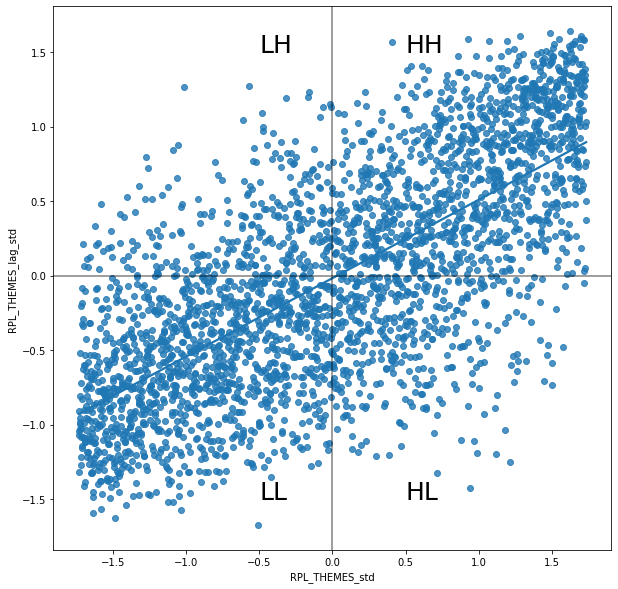

0.5271409932316937


In [36]:
#lets import the required libraries
import seaborn as sns
import pandas as pd
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
from scipy.stats import linregress
#Lets create a weight matrix for our SOVI tracts data using queens contiguity 
w = weights.Queen.from_dataframe(oh_svi_valid, idVariable='FIPS')
# Row standardize the matrix
w.transform = 'R'
# calculate the spatial lag for RPL_THEMES and create a new variable as RPL_THEMES_lag
oh_svi_valid['RPL_THEMES_lag']=weights.lag_spatial(w, oh_svi_valid.RPL_THEMES)
# now standardize RPL_THEMES and create a lag variable for the standardized RPL_THEMES
oh_svi_valid['RPL_THEMES_std']=(oh_svi_valid['RPL_THEMES'] - oh_svi_valid['RPL_THEMES'].mean()) / oh_svi_valid['RPL_THEMES'].std()
oh_svi_valid['RPL_THEMES_lag_std']=weights.lag_spatial(w, oh_svi_valid['RPL_THEMES_std'])

# Draw the Moran plot which is a scatter plot between the standardized spatial lag variable and the standardized vairable
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot values
sns.regplot(x='RPL_THEMES_std', y='RPL_THEMES_lag_std', data=oh_svi_valid, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(0.5, 1.5, "HH", fontsize=25)
plt.text(0.5, -1.5, "HL", fontsize=25)
plt.text(-.5, 1.5, "LH", fontsize=25)
plt.text(-.5, -1.5, "LL", fontsize=25)
f.savefig('../images/MoranI_SOVI.png',dpi=300)
# Display
plt.show()

#we can also calculate the slope of this line
slope, intercept, r_value, p_value, std_err = linregress(oh_svi_valid['RPL_THEMES_std'], oh_svi_valid['RPL_THEMES_lag_std'])
print (slope)

Lets use our SOVI data for generating Moran's plot
![Package](../images/MoranI_SOVI.png)

The plot displays a *positive relationship* between both variables. This is generally associated with the presence of *positive spatial autocorrelation*: *similar values tend to be located close to each other*. This means that the overall trend is for high values to be close to other high values, and for low values to be surrounded by other low values. The slope value is 0.52 which clearly indicates a positive correlation.

### Global Moran's I
Global Moran's I is a statistical measure that summarizes the spatial autocorrelation. Formally
$$I = \frac{N}{S} \frac{\sum_{i}\sum_{j}w_{ij}(y_i-\overline{y})(y_j-\overline{y})}{\sum_{i}(y_i-\overline{y})^2}$$
where N is the number of observations, S is the sum of weights, *w<sub>ij</sub>* is an element of the spatial weights matrix *W*, *y<sub>i</sub>* and *y<sub>j</sub>* are the values on the random variable at locations *i* and *j*, and <span style="text-decoration:overline">*y*</span> is the mean on *y*. A positive global Moran's I that differs significantly from the expected expected value under null indicates positive spatial autocorrelation - the clustering of similar value among neighboring observations. A negative global Moaran's I that differs significantly from the expected value under the null indicates a negative spatial autocorrelation - the clustering of dissimilar values on the random variable among neighboring observations. 
Now let's calculate Morans'I for our RPL_THEMES variable.

0.527320476034973
0.001


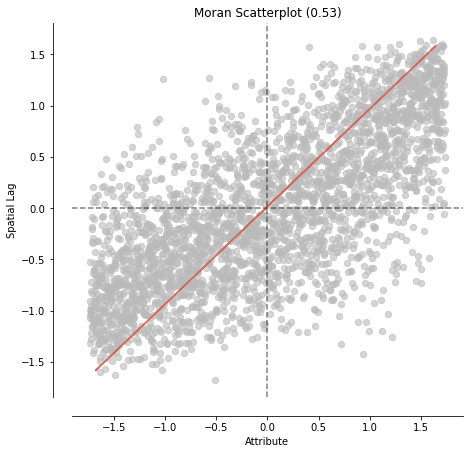

In [25]:
mi = esda.Moran(oh_svi_valid['RPL_THEMES'], w)
print (mi.I)
print (mi.p_sim)
moran_scatterplot(mi);

##### The Moran's I value is 0.53 indicating a positive spatial autocorrelation. 

The *p_sim* value relates to statistical significance: how likely is the pattern we observe in the map and Moran's I captures in its value to be generated by an entirely random process? The *p_sim* value of 0.001 indicates that if we generated a large number of maps with the same values but randomly allocated across space 99.9% of the time the I value calculated will be less than the observed I value of 0.53, indicating statistical significance for I value. 

![Package](../images/montecarlo.png)

In [33]:
w_knn_5 = weights.KNN.from_dataframe(oh_svi_valid, k=5)
mi = esda.Moran(oh_svi_valid['RPL_THEMES'], w_knn_5)
print (mi.I)
w_knn_10 = weights.KNN.from_dataframe(oh_svi_valid, k=10)
mi = esda.Moran(oh_svi_valid['RPL_THEMES'], w_knn_10)
print (mi.I)
w_knn_100 = weights.KNN.from_dataframe(oh_svi_valid, k=100)
mi = esda.Moran(oh_svi_valid['RPL_THEMES'], w_knn_100)
print (mi.I)

0.5137515245078326
0.4593504325496781
0.1574469510758433


### What do you think would happen to Spatial Autocorrelation, if we increase the number of neighbors

## Local Measures of Spatial Autocorrelation
While Moran's I is a __good tool to summarize a dataset into a single value__ that informs about its degree of *clustering*, it is __not appropriate measure to identify__ areas within the map where specific values are located. While Moran's I can tell us values are __clustered overall__, but it will not inform us __*where*__ these clusters are. __*Local*__ measures of autocorrelation helps to identify __*where*__ in the study region there are interesting or anomalous data patterns. Anselin (1995) defintes Local Indicators of Spatial Association (LISA) statistic as any statistic that satisfies two condtions
<ul>
<li> The LISA for each observation measures the extent of significant spatial clustering of similar values around the observation. </li>
<li>The sum of LISAs for all observations is proportional to a corresponding global indicator of spatial association. </li>
</ul>    


Local Moran, which is a LISA statistic, is formally defined as   
$$I_i = \frac{\sum_{j}w_{ij}(y_i-\overline{y})(y_j-\overline{y})}{(y_i-\overline{y})^2}$$   
Through the estimation of LISA statistics, the researcher can identify which observations are consistent with the global pattern of positive or negative spatial autocorrelation and which observations run counter to its global pattern.  The core idea is to identify cases in which the comparison between the value of an observation and the average of its neighbors is either more similar (HH, LL) or dissimilar (HL, LH) than we would expect from pure chance.
Let's use the same dataset to calculate Local Moran

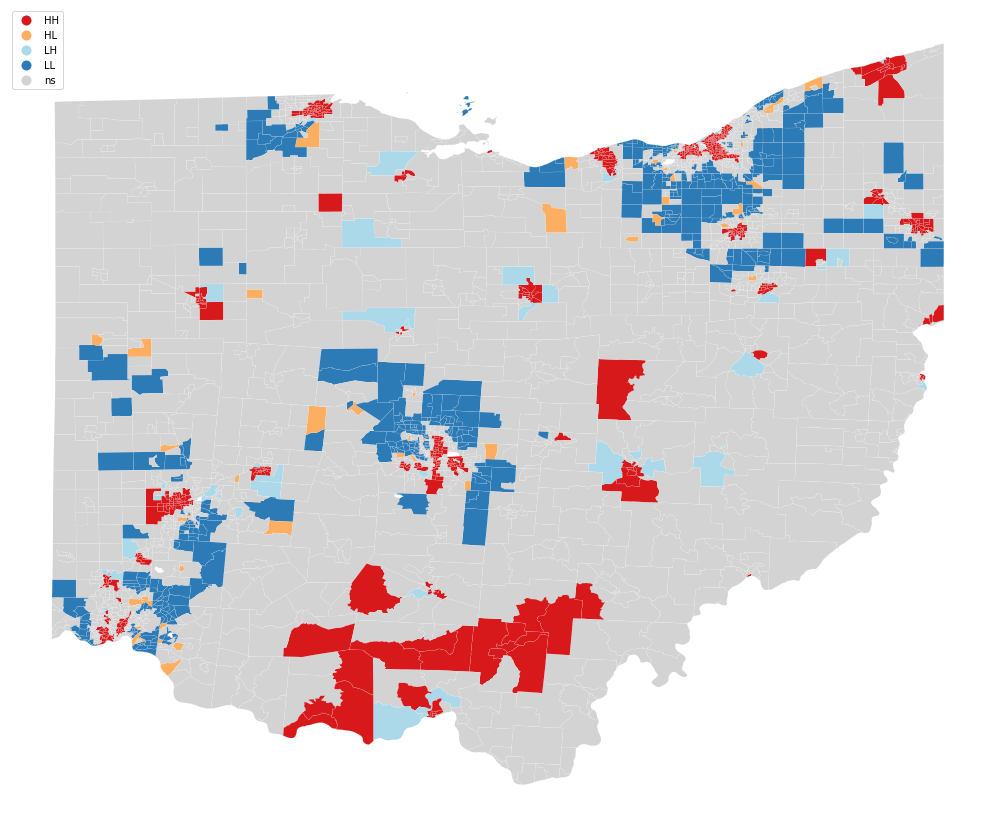

In [34]:
w_knn_5 = weights.KNN.from_dataframe(oh_svi_valid, k=5)
lisa = esda.Moran_Local(oh_svi_valid['RPL_THEMES'], w_knn_5)
oh_svi_valid['significant'] = lisa.p_sim < 0.05
oh_svi_valid['quadrant'] = lisa.q
fig, ax = plt.subplots(figsize=(18,15))
lisa_cluster(lisa, oh_svi_valid,ax=ax,legend_kwds={'loc': 'upper left'});
#fig.savefig('../images/lisa_sovi.png',dpi=300)

![Package](../images/lisa_sovi.png)

Lets take another example

In [28]:
#load the ohio breast cancer dataset aggregated to counties
oh_counties_bcancer=gpd.read_file(r'../class_data/ohio_breast_cancer_dataset.shp')
oh_counties_bcancer

,COUNTY_CD,COUNTY,COUNTY_SEA,ODOT_DISTR,FIPS_COUNT,POP_2010,POP_2000,POP_1990,STATE_PLAN,ELEVATION_,...,created_us,created_da,last_edite,last_edi_1,SHAPE_STAr,SHAPE_STLe,county_low,county_1,Breast,geometry
0,LUC,LUCAS,TOLEDO,2,39095,441815,455054,462361,N,715,...,TIMS@P31_AG,2021-07-27,TIMS@P31_AG,2021-07-27,1.610474e+09,270990.965727,lucas,Lucas,66.5,"POLYGON ((-9290122.672 5120504.038, -9290126.3..."
1,COS,COSHOCTON,COSHOCTON,5,39031,36901,36655,35427,N,1300,...,TIMS@P31_AG,2021-07-27,TIMS@P31_AG,2021-07-27,2.529116e+09,213121.169057,coshocton,Coshocton,61.2,"POLYGON ((-9144444.121 4932259.231, -9142650.4..."
2,BRO,BROWN,GEORGETOWN,9,39015,44846,42285,34966,S,1090,...,TIMS@P31_AG,2021-07-27,TIMS@P31_AG,2021-07-27,2.114031e+09,243300.067767,brown,Brown,53.9,"POLYGON ((-9338953.591 4757373.445, -9337293.0..."
3,HIG,HIGHLAND,HILLSBORO,9,39071,43589,40875,35728,S,1340,...,TIMS@P31_AG,2021-07-27,TIMS@P31_AG,2021-07-27,2.407747e+09,213157.741018,highland,Highland,59.1,"POLYGON ((-9281908.238 4763814.016, -9281886.2..."
4,HOL,HOLMES,MILLERSBURG,11,39075,42366,38943,32849,N,1380,...,TIMS@P31_AG,2021-07-27,TIMS@P31_AG,2021-07-27,1.905310e+09,193044.918259,holmes,Holmes,44.6,"POLYGON ((-9089125.135 4963457.660, -9089119.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,LOG,LOGAN,BELLEFONTAINE,7,39091,45858,46005,42310,N,1549,...,TIMS@P31_AG,2021-07-27,TIMS@P31_AG,2021-07-27,2.086155e+09,190284.032265,logan,Logan,57.3,"POLYGON ((-9337476.741 4944528.262, -9337463.3..."
84,MED,MEDINA,MEDINA,3,39103,172332,151095,122354,N,1320,...,TIMS@P31_AG,2021-07-27,TIMS@P31_AG,2021-07-27,1.932137e+09,192276.626187,medina,Medina,70.3,"POLYGON ((-9093238.201 5041959.343, -9093249.9..."
85,NOB,NOBLE,CALDWELL,10,39121,14645,14058,11336,S,1340,...,TIMS@P31_AG,2021-07-27,TIMS@P31_AG,2021-07-27,1.776302e+09,232976.730267,noble,Noble,42.0,"POLYGON ((-9055592.068 4859200.890, -9052584.5..."
86,PIK,PIKE,WAVERLY,9,39131,28709,27695,24249,S,1320,...,TIMS@P31_AG,2021-07-27,TIMS@P31_AG,2021-07-27,1.910697e+09,192107.489157,pike,Pike,69.4,"POLYGON ((-9216977.711 4730163.159, -9217256.9..."


<AxesSubplot:>

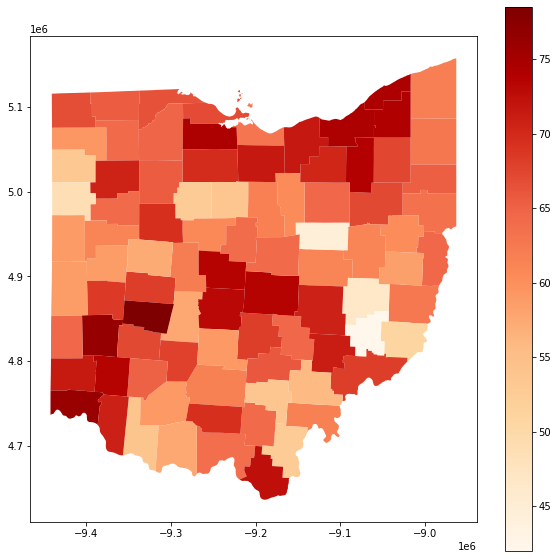

In [29]:
fig,ax=plt.subplots(figsize=(10,10))
oh_counties_bcancer.plot('Breast',cmap='OrRd',ax=ax,legend=True)

In [30]:
#lets generate a weight matrix using queen contiguity and use county as idvariable
w_b_cancer = weights.Queen.from_dataframe(oh_counties_bcancer, idVariable='COUNTY')
# Row standardize the matrix
w_b_cancer.transform = 'R'

-0.015531825944598374
0.487


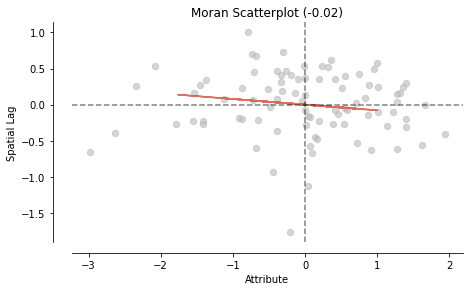

In [31]:
mi = esda.Moran(oh_counties_bcancer['Breast'], w_b_cancer)
print (mi.I)
print (mi.p_sim)
moran_scatterplot(mi);

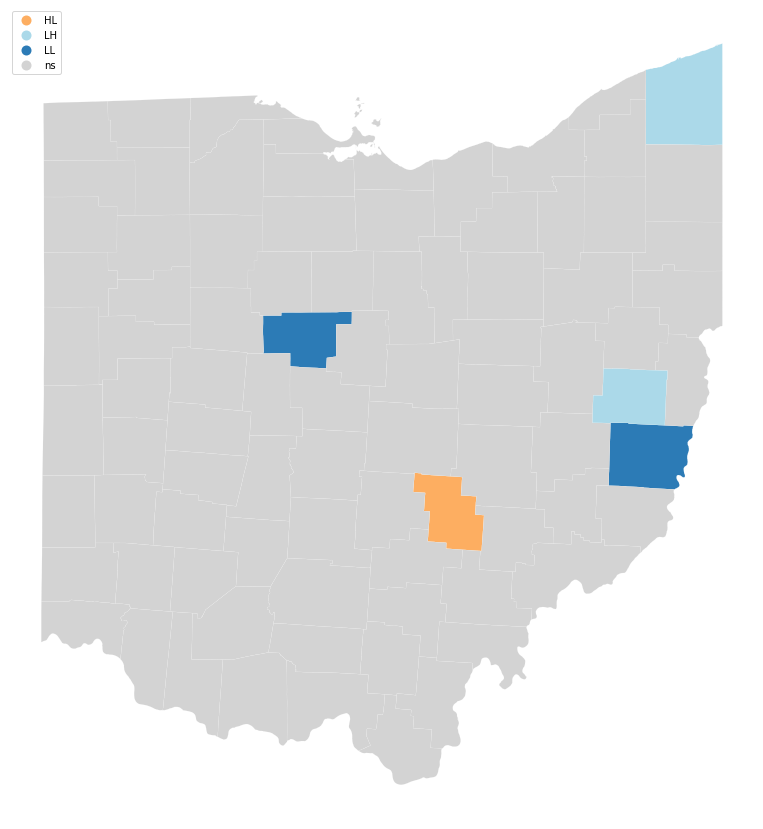

In [35]:
lisa = esda.Moran_Local(oh_counties_bcancer['Breast'], w_b_cancer)
oh_counties_bcancer['significant'] = lisa.p_sim < 0.05
oh_counties_bcancer['quadrant'] = lisa.q
fig, ax = plt.subplots(figsize=(18,15))
lisa_cluster(lisa, oh_counties_bcancer,ax=ax,legend_kwds={'loc': 'upper left'});
fig.savefig('../images/lisa_breast_cancer.png',dpi=300)

![Package](../images/lisa_breast_cancer.png)